
## Quantum Anomaly Detection with Quantum Density Estimation

### Anomaly Detection with RFF



### Qiskit Hackathon Global 2021

---

**Group: Quantum Mind UN**

Diego Useche - diusecher@unal.edu.co

Oscar Alberto Bustos B. - oabustosb@unal.edu.co

**The problem:**

Anomaly Detection: 
A common need when analyzing datasets is to find which observations deviates considerably from others. Such instances are known as anomalies or outliers, and the goal of anomaly detection (AD) is to detect those atypical or irregular data, generally in unsupervised scenarios. AD has many applications across a wide variety of domains, including intrusion or fraud detection in cybersecurity, industrial monitoring, disease detection for medical diagnosis and rare event detection in science.

Can we build a quantum circuit to perform Anomaly Detection?

**Our Approach**

Anomaly Detection based on Density Estimation:

*   Use normal data to induce a probability density function (pdf) (Density Estimation)
*   Use the pdf to estimate the density of new samples. If the density is below a threshold, then classify it as anomaly.

Quantum Density Estimation:

*   Combine Density Matrices with RFF [Rahimi2007] to perform Density Estimation [González2021]
*   Propose a quantum circuit to estimate expected values of density matrices.

**Main contributions**

*   We developed a new method for Anomaly Detection in quantum computers.
*   We implemented the method in a quantum circuit and showed that it’s a feasible approach.
*   Most quantum machine learning algorithms are based on pure states. Our 
algorithm can work with mixed states and pure states.
*   We develop a new method to calculate the expected value of a density matrix.
*  We used this method to approximate a probability density function (pdf) in a quantum computer.


## Data Load

We will work with the following datasets: 

*   SpamBase: dataset from UCI Machine Learning Repository, includes 3485 emails classified as spam or non-spam. This dataset has 58 attributes. We treat spam as outliers. The anomaly ratio is 0.2
*   Cardiotocography: data is also from UCI Machine Learning Repository and is related to heart diseases. This dataset contains 22 attributes. It describes 3
classes: normal, suspect, and pathological. Normal patients are treated as inliers and the remaining as outliers. The anomaly ratio is 0.2



### Imports and Libraries

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
!pip install qiskit
!pip install pylatexenc

     |████████████████████████████████| 6.1 MB 5.0 MB/s 
     |████████████████████████████████| 17.9 MB 112 kB/s 
     |████████████████████████████████| 237 kB 43.6 MB/s 
     |████████████████████████████████| 207 kB 47.4 MB/s 
     |████████████████████████████████| 2.1 MB 56.4 MB/s 
     |████████████████████████████████| 1.4 MB 54.0 MB/s 
     |████████████████████████████████| 634 kB 52.7 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 
     |████████████████████████████████| 38.2 MB 25 kB/s 
     |████████████████████████████████| 943 kB 10 kB/s 
     |████████████████████████████████| 3.5 MB 44.6 MB/s 
     |████████████████████████████████| 6.3 MB 34.4 MB/s 
  Created wheel for qiskit: filename=qiskit-0.32.0-py3-none-any.whl size=11773 sha256=0e0a8f61973bfacbfac251dd07a663d0f6707738f0cbc5e4e4014557db3dbd72
  Stored in directory: /root/.cache/pip/wheels/95/84/c4/6a084a33c1909266fca66eed2303c3883e03f33c905b1eb

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute

### Load from Drive

In [ ]:
#Loading SpamBase dataset file
!gdown --id 1Hdq-Svp31YkTj7wFZY3D2fsnBM1tbr_t

Downloading...
From: https://drive.google.com/uc?id=1Hdq-Svp31YkTj7wFZY3D2fsnBM1tbr_t
To: /content/SpamBase.npy
100% 1.65M/1.65M [00:00<00:00, 52.5MB/s]


In [ ]:
#Loading Cardiotocography dataset file
!gdown --id 1sVygYNPrTQI9d-8kVnx7w5nGWOSosveX

Downloading...
From: https://drive.google.com/uc?id=1sVygYNPrTQI9d-8kVnx7w5nGWOSosveX
To: /content/Cardiotocography.npy
100% 379k/379k [00:00<00:00, 79.9MB/s]


In [ ]:
spambase = np.load("SpamBase.npy")

cardio = np.load("Cardiotocography.npy")

### Preprocessing

This function extracts and separates the features and the labels from the whole dataset. We will apply it to both datasets. Normal data will be labeled as '1' and anomalies will be labeled as '0'.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def preprocessing(data):
    features = data[:,:-1]
    labels = data[:,-1]

    scaler = MinMaxScaler()
    scaler.fit(features)
    features = scaler.transform(features)

    labels = labels[:,np.newaxis]
    labels[labels == -1] = 0

    return features, labels

In [ ]:
spam_X, spam_y = preprocessing(spambase)
cardio_X, cardio_y = preprocessing(cardio)

In [ ]:
spam_X.shape

(3485, 58)

In [ ]:
cardio_X.shape

(2060, 22)

## Random Fourier Features

To perform dimensionality reduction, we will use Random Fourier Features, an approach stablished by Rahimi and Recht, 2007. RFF is a type of quantum feature map from data to quantum states, in such a way that it can fit more precisely the underlying probability distribution of data.


In [ ]:
from sklearn.kernel_approximation import RBFSampler
"""
  Code from https://arxiv.org/abs/2004.01227
"""
class QFeatureMap: 

  def get_dim(self, num_features):
    pass

  def batch2wf(self, X):
    pass

  def batch2dm(self, X):
    pass

  def batch2dm(self, X):
    psi = self.batch2wf(X)
    rho = np.einsum('...i,...j', psi, np.conj(psi))
    return rho

class QFeatureMap_rff(QFeatureMap):

  def __init__(self, rbf_sampler):
    self.rbf_sampler = rbf_sampler
    self.weights = np.array(rbf_sampler.random_weights_)
    self.offset = np.array(rbf_sampler.random_offset_)
    self.dim = rbf_sampler.get_params()['n_components']

  def get_dim(self, num_features):
    return self.dim

  def batch2wf(self, X):
    vals = np.dot(X, self.weights) + self.offset
    vals = np.cos(vals)
    vals *= np.sqrt(2.) / np.sqrt(self.dim)
    norms = np.linalg.norm(vals, axis=1)
    psi = vals / norms[:, np.newaxis]
    return psi

## Cardio 4x4 Mixed State

First, we will work with Cardiotocography dataset.

The number of RFF we will use depends on the size of the density matrix we will build. In this case, we will use a 4x4 density matrix, so we will reduce our samples to arrays of length 4. Transforming each sample will allow us to convert those values into two-qubit states. 

In [ ]:
# Create the RandomFourierFeature map
dim = 4
rm_state = 2
sigma = 1.5  #dataset dependant
gamma = 1 / (2 * sigma**2)

feature_map_fourier = RBFSampler(gamma=gamma, n_components=dim, random_state=rm_state)
X_feat_train = feature_map_fourier.fit(cardio_X)

rffmap = QFeatureMap_rff(rbf_sampler=feature_map_fourier)

Crff = rffmap.batch2wf(cardio_X)

print(Crff.shape)

(2060, 4)


Once our samples have been reduced, it's important to normalize them. Also we will split the dataset into three groups, a training partition with only normal data (70%), and a test partition with a group of normal data (10%) and a group of outlier data (20%).

In [ ]:
Cones = []
Ctrain = []
Ctest_zeros = []
Ctest_ones = []

for i in range(Crff.shape[0]):
    if (cardio_y[i] == 1):
        Cones.append(Crff[i] / np.linalg.norm(Crff[i]))
    elif (cardio_y[i] == 0):
        Ctest_zeros.append(Crff[i] / np.linalg.norm(Crff[i]))

Ctest_ones = Cones[:len(Ctest_zeros)//2]
Ctrain = Cones[len(Ctest_zeros)//2:]

print(len(Ctrain))
print(len(Ctest_zeros))
print(len(Ctest_ones))

1442
412
206


In [ ]:
print(Ctrain[0])
print(sum(Ctrain[0]**2))

[ 0.6607845   0.60963091 -0.29528374 -0.32329786]
1.0000000000000002


Now, we will define the training state using the Mixed State approach. We will use the density matrix corresponding to the training state, $\rho_1$. So we have

$$
\rho_1 = \frac{1}{m} \sum |\phi_1 \rangle \langle \phi_1 |
$$

being $|\phi_1 \rangle$ the states labeled with '1' (aka training normal data), and $m$ the amount of samples. To construct the density matrices, only train samples will be used.

In [ ]:
import copy
def round_lambda(lambda_param_2):
  lambda_param = copy.copy(lambda_param_2)
  for i in range(4):
    if lambda_param[i] < 0.00000001:
      lambda_param[i] = 0.00000001
  lambda_param[3] = 1 - lambda_param[0] - lambda_param[1] - lambda_param[2]
  return lambda_param

In [ ]:
Z_train = np.outer(np.abs(Ctrain[0]), np.abs(Ctrain[0]))
for i in range(1, len(Ctrain)):
    Z_train += np.outer(np.abs(Ctrain[i]), np.abs(Ctrain[i]))

Z_train *= 1/len(Ctrain)
print(Z_train)

[[0.28539094 0.21797308 0.12163383 0.28368129]
 [0.21797308 0.20571635 0.10524944 0.25986083]
 [0.12163383 0.10524944 0.08864394 0.14422189]
 [0.28368129 0.25986083 0.14422189 0.42024877]]


In [ ]:
lambda_P1_temp, U_train = np.linalg.eigh(Z_train)
lambda_train = round_lambda(lambda_P1_temp)
print(lambda_train)
print(U_train)

[0.01929039 0.02967972 0.06373443 0.88729546]
[[ 0.41964602 -0.29678184 -0.67344497 -0.53130936]
 [-0.87135899 -0.04328634 -0.15939879 -0.46200847]
 [ 0.11676352  0.94808647 -0.13909626 -0.26105661]
 [ 0.22582516 -0.10573021  0.70831923 -0.66038473]]


In [ ]:
lambda_train = lambda_train / np.linalg.norm(lambda_train)
print(lambda_train)
print((sum(lambda_train**2)))

[0.02166764 0.0333373  0.07158875 0.99664145]
0.9999999999999999


The quantum circuit we propose will be based in a Qiskit gate called `Isometry`, that allows to prepare arbitrary unitary rotations.

We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained. This value will be proportional to the density value estimated by the circuit.

In [ ]:
backend2 = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [ ]:
## Density Estimation Approach matrices 4x4
Cpred_ones = []

for i in range(len(Ctest_ones)):

    qc = QuantumCircuit(4, 2)

    qc.initialize(Ctest_ones[i], [0, 1])
    qc.initialize(lambda_train, [2, 3])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.cnot(3, 1)
    qc.cnot(2, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend2, shots=20000).result().get_counts()
    Cpred_ones.append((counts['00'])/5000)

print(Cpred_ones)

# Works

[0.214, 0.0926, 0.0502, 0.1488, 0.0394, 0.024, 1.7982, 0.139, 0.215, 0.0768, 0.8086, 0.0146, 1.2966, 0.3184, 0.5238, 0.0308, 1.652, 1.8776, 1.1904, 1.6002, 2.102, 1.6478, 2.3404, 3.03, 1.912, 0.6914, 2.5166, 0.8448, 1.0294, 1.9948, 1.7792, 2.6616, 0.1438, 0.2088, 0.365, 0.016, 0.0134, 0.0192, 0.0416, 0.0148, 0.0114, 0.4522, 0.0524, 0.0104, 0.025, 0.0088, 0.0356, 0.0512, 0.0162, 0.0168, 0.0122, 0.032, 0.0128, 0.0122, 0.0154, 0.0136, 0.0238, 0.023, 0.0346, 0.0196, 0.0152, 0.0166, 0.0266, 0.0202, 0.0176, 2.2426, 0.406, 0.7414, 0.1448, 0.3144, 0.185, 0.1002, 0.4938, 1.2452, 0.8562, 0.1414, 1.4406, 0.7256, 0.4566, 0.2614, 2.3354, 2.038, 0.7778, 0.8568, 1.2222, 2.0038, 1.44, 0.977, 1.8636, 0.0114, 0.0584, 0.0152, 0.0418, 0.0548, 0.0428, 0.0394, 0.07, 0.0514, 0.0114, 0.0216, 0.0282, 0.013, 0.0132, 0.012, 0.0152, 0.0102, 0.0154, 0.1048, 0.8522, 0.6226, 1.0562, 0.994, 0.9546, 2.4066, 1.6386, 1.971, 1.9234, 0.4604, 1.1696, 0.8214, 0.0248, 0.0176, 0.022, 0.0766, 1.7426, 1.5724, 1.8348, 0.6992, 0.

In [ ]:
# Mixed state case
Cpred_zeros = []

for i in range(len(Ctest_zeros)):

    qc = QuantumCircuit(4, 2)
    
    qc.initialize(Ctest_zeros[i], [0, 1])
    qc.initialize(lambda_train, [2, 3])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.cnot(3, 1)
    qc.cnot(2, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend2, shots=20000).result().get_counts()
    Cpred_zeros.append((counts['00'])/5000)

print(Cpred_zeros)

Once we have obtained the predicted density values, we need to determine a threshold $t$ such that if a sample has a density value lower than $t$, it is classified as an outlier. For this, we will define a validation partition from our test groups, and we'll try to find the best possible value for $t$ using only validation samples (based on the best possible value of weighted F1-score). After that, we'll use this threshold to compare with all the remaining test samples. 

In [ ]:
Cpred_val = np.concatenate((Cpred_ones[:100], Cpred_zeros[:100]))
print(Cpred_val.shape)

Cy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Cy_val.shape)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Cy_val, Cpred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [ ]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Cpred_val > t).astype(int)
    metric = f1_score(Cy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

We have obtained that our best threshold is at $t = 0.3655$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [ ]:
Cpr_zeros = (np.array(Cpred_zeros) > T).astype(int)

Cpr_ones = (np.array(Cpred_ones) > T).astype(int)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(106), np.zeros(312))), 
        np.concatenate((Cpr_ones[100:], Cpr_zeros[100:])), digits=4))

## Cardio 4x4 Pure State


Now, we will define another way to represent the training density matrix: the Pure State approach. First, we will define the state  $|\psi_1 \rangle$. 

$$
 |\psi_1 \rangle = \frac {\sum |\phi_1 \rangle} {\left \| \sum |\phi_1 \rangle \right \|}
$$

being $|\phi_1 \rangle$ the states labeled with '1'. To construct this state, only train samples will be used.

Once obtained this state, it represents all the information from training states. So we build the density matrix as

$$
\rho_1 = |\psi_1 \rangle \langle ψ_1 |
$$

In [ ]:
# Given the eigenvalues this function return a Unitary gate which converts the |0> -> |lambda>
def create_U_train(x_train_param, seed=0):
  np.random.seed(seed)
  size_U = len(x_train_param)
  U_train = np.zeros((size_U, size_U))
  x_1 = x_train_param
  U_train[:, 0] = x_1
  for i in range(1, size_U):
    x_i = np.random.randn(size_U)
    for j in range(0, i):
      x_i -= x_i.dot(U_train[:, j]) * U_train[:, j]
    x_i = x_i/np.linalg.norm(x_i)
    U_train[:, i] = x_i
  
  return U_train

In [ ]:
phi_train = np.sum(np.abs(Ctrain), axis=0)
phi_train = phi_train / np.linalg.norm(phi_train)

U_train = create_U_train(phi_train)

print(U_train)

We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained.

In [ ]:
backend = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [ ]:
## Density Estimation Approach matrices 4x4
Cpred_ones = []

for i in range(len(Ctest_ones)):

    qc = QuantumCircuit(2, 2)
    qc.initialize(Ctest_ones[i], [0, 1])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend, shots=20000).result().get_counts()
    try:
        Cpred_ones.append((counts['00'])/5000)
    except:
        Cpred_ones.append(0)

print(Cpred_ones)

# Works

[0.2015, 0.0845, 0.046, 0.126, 0.027, 0.0025, 1.7915, 0.132, 0.1895, 0.05, 0.7675, 0.0005, 1.3065, 0.283, 0.5565, 0.0245, 1.641, 1.893, 1.217, 1.596, 2.142, 1.6305, 2.354, 3.059, 1.9805, 0.698, 2.558, 0.855, 1.034, 2.024, 1.853, 2.6855, 0.1475, 0.198, 0.3525, 0.0105, 0.0025, 0.0105, 0.0315, 0.004, 0, 0.4475, 0.0385, 0.003, 0.014, 0.001, 0.0185, 0.0435, 0.003, 0.003, 0.001, 0.018, 0.002, 0, 0.0055, 0.0005, 0.0105, 0.009, 0.0235, 0.0075, 0.001, 0.0035, 0.015, 0.0065, 0.0075, 2.2975, 0.4105, 0.7435, 0.1265, 0.308, 0.195, 0.0805, 0.473, 1.2275, 0.8425, 0.136, 1.4455, 0.6975, 0.4515, 0.28, 2.296, 2.0645, 0.779, 0.892, 1.22, 2.009, 1.483, 0.936, 1.873, 0.0005, 0.0465, 0.0035, 0.028, 0.0425, 0.0355, 0.0275, 0.0755, 0.04, 0.0005, 0.0065, 0.0145, 0.001, 0, 0, 0.0015, 0.0015, 0.0015, 0.101, 0.9155, 0.6555, 1.039, 1.027, 0.9565, 2.4615, 1.702, 1.978, 1.9045, 0.481, 1.1325, 0.8745, 0.009, 0.0105, 0.0125, 0.064, 1.7515, 1.574, 1.853, 0.723, 0.67, 1.2235, 1.065, 0.2645, 2.0885, 0.945, 2.1515, 1.343,

In [ ]:
# Pure state case
Cpred_zeros = []

for i in range(len(Ctest_zeros)):

    qc = QuantumCircuit(2, 2)
    qc.initialize(Ctest_zeros[i], [0, 1])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend, shots=20000).result().get_counts()
    try:
        Cpred_zeros.append((counts['00'])/5000)
    except:
        Cpred_zeros.append(0)

print(Cpred_zeros)

[0.054, 0.0995, 0.013, 0.006, 0.0005, 0.563, 0.8145, 0.0685, 0, 0.072, 1.2155, 0, 1.1995, 0.0085, 0.026, 0.1275, 0.36, 0.252, 0.2375, 0.2825, 0, 0.0065, 0.005, 0.5585, 0.1845, 0.007, 0.0005, 0.0055, 0.0075, 0.0225, 0.2835, 0.3345, 0.009, 0.781, 1.246, 0.525, 0.008, 0, 0.0485, 0.0205, 0.12, 0, 0.0125, 0.1005, 0.0375, 0.6595, 0, 0.2825, 0.0085, 0.061, 0.077, 0, 0.051, 0.3545, 0.0005, 0.3105, 0.0275, 0.1365, 0.066, 0.343, 0.0945, 0.0485, 0.588, 0.0135, 1.013, 0, 0.0015, 0.2535, 0.0035, 0.085, 1.1795, 0.5885, 0.0015, 0.869, 0.02, 0.018, 0.001, 0.0105, 0.413, 0.782, 0.3035, 0.0415, 1.5995, 0.7235, 0.128, 0.015, 0, 0.005, 0.874, 0.324, 0.006, 0.0035, 0.0025, 0.053, 0.049, 0.0915, 0.0415, 0.001, 0.0965, 1.4545, 0.0005, 0.229, 0.013, 0.0215, 0.0685, 0.366, 0, 0.074, 0.0105, 0.003, 0.01, 0.0375, 0.4805, 0.004, 0.0755, 0.008, 0.0395, 0.0575, 0.3215, 0.0085, 0.017, 0.0025, 0.4065, 0.0305, 0.0455, 0.11, 0.01, 0.017, 0.001, 0.111, 0.871, 0, 0.2715, 0.002, 0.0695, 0.0475, 0.005, 0.1125, 0.008, 0.003

Once we have obtained the predicted density values, we need to determine a threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. For this, we will define a validation partition from our test groups, and we'll try to find the best possible value for $t$ (based on weighted F1-score) using only validation samples. After that, we'll use this threshold to compare with all the remaining test samples. 

In [ ]:
Cpred_val = np.concatenate((Cpred_ones[:100], Cpred_zeros[:100]))
print(Cpred_val.shape)

Cy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Cy_val.shape)

(200,)
(200,)


0.5981


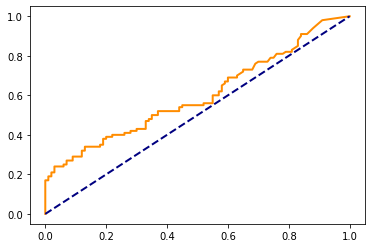

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Cy_val, Cpred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [ ]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Cpred_val > t).astype(int)
    metric = f1_score(Cy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.413


We have obtained that our best threshold is at $t = 0.413$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [ ]:
Cpr_zeros = (np.array(Cpred_zeros) > T).astype(int)

Cpr_ones = (np.array(Cpred_ones) > T).astype(int)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(106), np.zeros(312))), 
        np.concatenate((Cpr_ones[100:], Cpr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.8399    0.8910    0.8647       312
         1.0     0.6092    0.5000    0.5492       106

    accuracy                         0.7919       418
   macro avg     0.7245    0.6955    0.7070       418
weighted avg     0.7814    0.7919    0.7847       418



## Cardio 8x8 Mixed State

Now, we will use a 8x8 density matrix, so we will call a new RFF sampler to reduce our samples to arrays of length 8. Transforming each sample will allow us to convert those values into two-qubit states. 

In [ ]:
# Create the RandomFourierFeature map
dim = 8
rm_state = 2
sigma = 1.5  #dataset dependant
gamma = 1 / (2 * sigma**2)

feature_map_fourier = RBFSampler(gamma=gamma, n_components=dim, random_state=rm_state)
X_feat_train = feature_map_fourier.fit(cardio_X)

rffmap = QFeatureMap_rff(rbf_sampler=feature_map_fourier)

Crff = rffmap.batch2wf(cardio_X)

print(Crff.shape)

(2060, 8)


In [ ]:
Cones = []
Ctrain = []
Ctest_zeros = []
Ctest_ones = []

for i in range(Crff.shape[0]):
    if (cardio_y[i] == 1):
        Cones.append(Crff[i] / np.linalg.norm(Crff[i]))
    elif (cardio_y[i] == 0):
        Ctest_zeros.append(Crff[i] / np.linalg.norm(Crff[i]))

Ctest_ones = Cones[:len(Ctest_zeros)//2]
Ctrain = Cones[len(Ctest_zeros)//2:]

print(len(Ctrain))
print(len(Ctest_zeros))
print(len(Ctest_ones))

1442
412
206


In [ ]:
print(Ctrain[0])
print(sum(Ctrain[0]**2))

[ 0.45302627  0.48066672  0.39341633  0.02643167 -0.45585263  0.42733187
  0.13250014  0.01677011]
0.9999999999999999


In [ ]:
Z_train = np.outer(np.abs(Ctrain[0]), np.abs(Ctrain[0]))
for i in range(1, len(Ctrain)):
    Z_train += np.outer(np.abs(Ctrain[i]), np.abs(Ctrain[i]))

Z_train *= 1/len(Ctrain)
print(Z_train)

[[0.09403968 0.11342847 0.11443919 0.08022018 0.11041908 0.10061245
  0.03776868 0.07929061]
 [0.11342847 0.1772893  0.17837182 0.11881422 0.17201055 0.15747309
  0.05284141 0.11505695]
 [0.11443919 0.17837182 0.18674813 0.12177096 0.17508085 0.16288168
  0.05327093 0.12032412]
 [0.08022018 0.11881422 0.12177096 0.10021428 0.11710474 0.11107623
  0.03627804 0.07623142]
 [0.11041908 0.17201055 0.17508085 0.11710474 0.17365567 0.15717696
  0.0512283  0.1112635 ]
 [0.10061245 0.15747309 0.16288168 0.11107623 0.15717696 0.15136805
  0.04690002 0.10472527]
 [0.03776868 0.05284141 0.05327093 0.03627804 0.0512283  0.04690002
  0.02382305 0.03774223]
 [0.07929061 0.11505695 0.12032412 0.07623142 0.1112635  0.10472527
  0.03774223 0.09286184]]


In [ ]:
lambda_P1_temp, U_train = np.linalg.eigh(Z_train)
lambda_train = round_lambda(lambda_P1_temp)
print(lambda_train)
print(U_train)

[0.00249992 0.00366071 0.00566582 0.98817355 0.01189256 0.01993744
 0.02346068 0.92597342]
[[-0.01908266 -0.10728949  0.09923328  0.2770666   0.37310267  0.46527216
  -0.68053859  0.28756759]
 [ 0.69899499  0.06961987 -0.44261374 -0.18261394  0.26442004 -0.11875085
   0.07720354  0.43280965]
 [-0.43307213 -0.64715466 -0.33970307  0.10127081 -0.04834919 -0.24078409
   0.1023804   0.44405974]
 [-0.04540449  0.13002963 -0.17242185 -0.06056506 -0.49554992  0.72782953
   0.28459714  0.30221221]
 [-0.47655819  0.59840474  0.09469492 -0.0740207   0.39542259 -0.11473368
   0.22125313  0.42647635]
 [ 0.29721548 -0.20047704  0.74998691  0.23256838 -0.08768977 -0.08546069
   0.28817368  0.39606364]
 [-0.07575347 -0.19022164  0.2772552  -0.89716308 -0.03936614  0.03101793
  -0.23699     0.1327744 ]
 [ 0.01566788  0.33684065 -0.02829192  0.1072084  -0.61430518 -0.40034708
  -0.50126668  0.291688  ]]


In [ ]:
lambda_train = lambda_train / np.linalg.norm(lambda_train)
print(lambda_train)
print((sum(lambda_train**2)))

[0.00184545 0.00270234 0.00418252 0.72947213 0.00877911 0.01471787
 0.01731873 0.68355584]
1.0


We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained. This value will be proportional to the density estimated by the circuit.

In [ ]:
backend2 = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [ ]:
## Density Estimation Approach matrices 8x8
Cpred_ones = []

for i in range(len(Ctest_ones)):

    qc = QuantumCircuit(6, 3)

    qc.initialize(Ctest_ones[i], [0, 1, 2])
    qc.initialize(lambda_train, [3, 4, 5])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.cnot(5, 2)
    qc.cnot(4, 1)
    qc.cnot(3, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)

    counts = execute(qc, backend2, shots=8000).result().get_counts()
    Cpred_ones.append((counts['000'])/2000)

print(Cpred_ones)

# Works

[0.582, 0.7405, 0.7865, 0.6385, 0.6905, 0.586, 0.3845, 0.264, 0.4535, 0.4285, 0.376, 0.3655, 0.0745, 0.0975, 0.0175, 0.318, 0.2875, 0.249, 0.295, 0.227, 0.2865, 0.233, 0.262, 0.228, 0.316, 0.4455, 0.393, 0.1855, 0.138, 0.272, 0.1655, 0.0505, 1.365, 1.143, 0.1715, 0.8755, 0.85, 0.8845, 0.903, 0.8395, 0.5705, 0.796, 1.002, 0.8945, 1.0305, 0.762, 1.1015, 1.0065, 0.5605, 0.546, 0.5435, 0.551, 0.674, 0.691, 0.873, 0.7945, 0.6925, 0.695, 0.495, 0.821, 0.673, 0.6415, 0.5745, 0.8, 0.857, 0.298, 0.5055, 0.5565, 0.586, 0.5755, 0.5675, 0.429, 0.2455, 0.4565, 0.4155, 0.5925, 0.4605, 0.4665, 0.681, 0.649, 0.1535, 0.0795, 0.5395, 0.565, 0.504, 0.637, 0.444, 0.452, 0.438, 1.0905, 0.9435, 1.0945, 0.9705, 1.5125, 1.3825, 1.378, 0.9735, 0.3145, 0.6, 0.6865, 0.6615, 0.7725, 1.0325, 0.7715, 1.0605, 1.0665, 0.9755, 0.6535, 0.461, 0.5655, 0.585, 0.532, 0.5325, 0.2435, 0.5475, 0.3075, 0.3045, 0.4895, 0.4745, 0.5525, 0.543, 0.505, 0.639, 0.5205, 0.5155, 0.4435, 0.4815, 0.5985, 0.5615, 0.56, 0.5285, 0.591, 0.4

In [ ]:
# Mixed state case
Cpred_zeros = []

for i in range(len(Ctest_zeros)):

    qc = QuantumCircuit(6, 3)

    qc.initialize(Ctest_zeros[i], [0, 1, 2])
    qc.initialize(lambda_train, [3, 4, 5])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.cnot(5, 2)
    qc.cnot(4, 1)
    qc.cnot(3, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)
    counts = execute(qc, backend2, shots=8000).result().get_counts()
    Cpred_zeros.append((counts['000'])/2000)

print(Cpred_zeros)

[1.289, 0.8135, 0.8265, 0.8385, 0.6745, 0.282, 0.406, 0.459, 0.8405, 0.2905, 0.421, 1.2525, 0.2025, 0.661, 0.67, 0.417, 0.409, 0.369, 0.277, 0.35, 0.7505, 0.823, 0.7235, 0.4875, 0.3795, 0.3525, 0.738, 0.8105, 0.379, 0.395, 0.571, 0.486, 0.427, 0.15, 0.2415, 0.193, 0.7945, 0.441, 0.3865, 0.3735, 0.632, 0.6295, 0.611, 0.5545, 0.3555, 0.5385, 0.66, 0.5935, 0.868, 0.5955, 0.588, 0.7985, 1.279, 0.487, 0.7705, 0.159, 0.5495, 0.2175, 0.799, 0.4585, 0.7815, 0.333, 0.4775, 0.6475, 0.3625, 0.316, 0.766, 0.47, 0.6195, 0.6305, 0.376, 0.48, 0.8625, 0.4095, 0.7575, 0.923, 0.572, 0.624, 0.2675, 0.44, 0.528, 0.7885, 0.3805, 0.467, 0.452, 0.726, 0.673, 0.7785, 0.4005, 0.4955, 0.895, 0.8355, 0.869, 0.767, 1.16, 0.331, 0.983, 0.7225, 0.745, 0.419, 0.837, 0.6305, 0.662, 0.3445, 0.4975, 0.478, 0.64, 0.5505, 0.756, 1.0525, 0.385, 0.6905, 0.3105, 0.861, 0.689, 0.9425, 1.1265, 0.6035, 0.3415, 0.8295, 0.321, 0.3915, 0.8405, 0.6795, 0.3545, 0.3255, 0.8415, 0.1805, 0.948, 0.4635, 0.5125, 0.777, 0.9665, 0.9265, 0

Once we have obtained the predicted density values, we need to determine a threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. For this, we will define a validation partition from our test groups, and we'll try to find the best possible value for $t$ using only validation samples. After that, we'll use this threshold to compare with all the remaining test samples. 

In [ ]:
Cpred_val = np.concatenate((Cpred_ones[:100], Cpred_zeros[:100]))
print(Cpred_val.shape)

Cy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Cy_val.shape)

(200,)
(200,)


0.49595


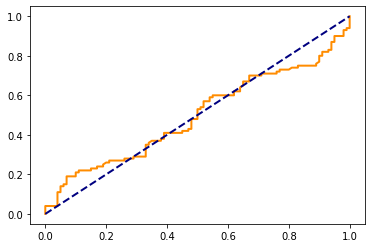

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Cy_val, Cpred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [ ]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Cpred_val > t).astype(int)
    metric = f1_score(Cy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.4955


We have obtained that our best threshold is at $t = 0.4955$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [ ]:
Cpr_zeros = (np.array(Cpred_zeros) > T).astype(int)

Cpr_ones = (np.array(Cpred_ones) > T).astype(int)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(106), np.zeros(312))), 
        np.concatenate((Cpr_ones[100:], Cpr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.7630    0.4231    0.5443       312
         1.0     0.2653    0.6132    0.3704       106

    accuracy                         0.4713       418
   macro avg     0.5142    0.5181    0.4574       418
weighted avg     0.6368    0.4713    0.5002       418



## Cardio 8x8 Pure State

In [ ]:
# Given the eigenvalues this function return a Unitary gate which converts the |0> -> |lambda>
def create_U_train(x_train_param, seed=0):
  np.random.seed(seed)
  size_U = len(x_train_param)
  U_train = np.zeros((size_U, size_U))
  x_1 = x_train_param
  U_train[:, 0] = x_1
  for i in range(1, size_U):
    x_i = np.random.randn(size_U)
    for j in range(0, i):
      x_i -= x_i.dot(U_train[:, j]) * U_train[:, j]
    x_i = x_i/np.linalg.norm(x_i)
    U_train[:, i] = x_i
  
  return U_train

In [ ]:
phi_train = np.sum(np.abs(Ctrain), axis=0)
phi_train = phi_train / np.linalg.norm(phi_train)

U_train = create_U_train(phi_train)

print(U_train)

[[ 0.28684681  0.36163466 -0.64907043  0.3039476   0.29823376 -0.3628901
   0.15672877 -0.16752971]
 [ 0.43304774 -0.19150853  0.0425077   0.01946241 -0.66638594 -0.35659966
  -0.20048597 -0.40271614]
 [ 0.44413513 -0.01120385 -0.3346563   0.02332315 -0.35547746  0.59271958
   0.24672536  0.38926279]
 [ 0.30137368  0.50622778  0.63860468  0.26581483  0.02231948  0.06976633
   0.39028257 -0.1294136 ]
 [ 0.42656204  0.29150598  0.0298679  -0.72831994  0.27817334  0.09661608
  -0.32529554 -0.09588955]
 [ 0.39638647 -0.61313144  0.11383773  0.26809529  0.49785862  0.24052065
  -0.04173887 -0.27323611]
 [ 0.13336378  0.21047524  0.11205656  0.46037306  0.02482021  0.01655667
  -0.74680723  0.39345019]
 [ 0.29196429 -0.26635886  0.17516306 -0.14753714  0.1194335  -0.5634755
   0.23825873  0.6346844 ]]


We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained.

In [ ]:
backend = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [ ]:
## Density Estimation Approach matrices 8x8
Cpred_ones = []

for i in range(len(Ctest_ones)):

    qc = QuantumCircuit(3, 3)
    qc.initialize(Ctest_ones[i], [0, 1, 2])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)

    counts = execute(qc, backend, shots=8000).result().get_counts()
    try:
        Cpred_ones.append((counts['000'])/2000)
    except:
        Cpred_ones.append(0)

print(Cpred_ones)

# Works

[0.944, 1.046, 1.618, 1.398, 1.4315, 0.99, 0.6885, 0.545, 0.922, 0.7625, 0.8095, 0.778, 0.0855, 0.189, 0.003, 0.6985, 0.482, 0.5125, 0.5885, 0.5135, 0.5615, 0.449, 0.5245, 0.4645, 0.554, 0.9335, 0.833, 0.2405, 0.221, 0.554, 0.3775, 0.0965, 2.651, 2.077, 0.369, 1.5015, 1.5525, 1.63, 1.706, 1.483, 0.9735, 1.723, 2.146, 1.6355, 2.2055, 1.169, 2.0875, 1.8345, 0.581, 0.709, 0.731, 0.8895, 1.0095, 1.4225, 1.255, 1.598, 1.3985, 1.2505, 0.917, 1.2905, 1.103, 1.091, 0.762, 1.195, 1.477, 0.575, 0.822, 1.178, 1.1725, 0.9355, 1.1505, 0.5525, 0.4035, 0.933, 0.7345, 1.2295, 0.979, 0.981, 1.176, 1.241, 0.2265, 0.196, 0.97, 0.9505, 0.897, 1.2865, 0.946, 0.94, 0.9065, 1.9495, 1.5245, 1.618, 1.6215, 2.8385, 2.482, 2.5285, 1.47, 0.6085, 1.237, 1.5035, 1.0695, 1.6945, 1.8315, 1.4275, 2.2175, 2.072, 2.0455, 1.3085, 0.512, 0.7275, 0.993, 1.0445, 0.9225, 0.3225, 0.921, 0.4145, 0.4395, 0.864, 0.8245, 1.1585, 0.367, 0.343, 0.4515, 0.694, 1.0725, 0.887, 0.944, 0.915, 0.953, 1.07, 0.87, 1.099, 0.8865, 0.9175, 0.

In [ ]:
# Pure state case
Cpred_zeros = []

for i in range(len(Ctest_zeros)):

    qc = QuantumCircuit(3, 3)
    qc.initialize(Ctest_zeros[i], [0, 1, 2])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)

    counts = execute(qc, backend, shots=8000).result().get_counts()
    try:
        Cpred_zeros.append((counts['000'])/2000)
    except:
        Cpred_zeros.append(0)

print(Cpred_zeros)

[1.968, 1.55, 1.1885, 1.5635, 1.008, 0.488, 0.8315, 0.012, 1.689, 0.4935, 0.219, 2.0725, 0.2575, 0.9815, 1.1325, 0.098, 0.0375, 0.5835, 0.0615, 0.707, 1.4355, 1.0385, 1.277, 0.8905, 0.8135, 0.71, 1.422, 1.3475, 0.4865, 0.716, 1.028, 0.9545, 0.006, 0.0725, 0.4385, 0.112, 1.4745, 0.5075, 0.678, 0.766, 1.22, 0.994, 1.1465, 1.0155, 0.529, 1.1415, 1.0565, 1.0785, 1.36, 1.0815, 1.0735, 1.382, 1.48, 0.921, 1.346, 0.172, 1.1, 0.3365, 1.5455, 0.9065, 1.401, 0.5875, 1.0055, 1.0735, 0.1675, 0.089, 1.5525, 1.0075, 1.044, 1.129, 0.264, 1.0665, 1.698, 0.807, 1.311, 1.5445, 1.1695, 1.1995, 0.4315, 0.798, 1.0855, 1.0635, 0.793, 0.8285, 0.5295, 1.35, 1.2945, 1.282, 0.8765, 0.9765, 1.9335, 1.71, 1.6965, 1.431, 1.822, 0.7005, 1.79, 1.156, 1.4425, 0.869, 0.9945, 1.2915, 1.114, 0.687, 0.896, 0.387, 1.2025, 1.0415, 1.157, 2.2335, 0.007, 1.1475, 0.5355, 1.2675, 1.499, 1.951, 1.7705, 1.073, 0.389, 1.6075, 0.694, 0.838, 1.59, 1.4195, 0.2455, 0.61, 1.766, 0.0085, 1.942, 0.925, 1.09, 1.3635, 1.983, 1.6115, 0.403

Once we have obtained the predicted density values, we need to determine a threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. For this, we will define a validation partition from our test groups, and we'll try to find the best possible value for $t$ using only validation samples. After that, we'll use this threshold to compare with all the remaining test samples. 

In [ ]:
Cpred_val = np.concatenate((Cpred_ones[:100], Cpred_zeros[:100]))
print(Cpred_val.shape)

Cy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Cy_val.shape)

(200,)
(200,)


0.5209


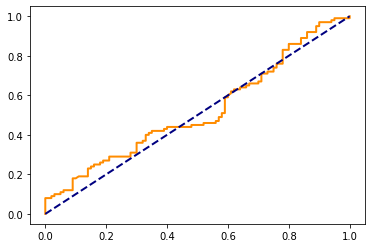

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Cy_val, Cpred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [ ]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Cpred_val > t).astype(int)
    metric = f1_score(Cy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

1.156


We have obtained that our best threshold is at $t = 1.156$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [ ]:
Cpr_zeros = (np.array(Cpred_zeros) > T).astype(int)

Cpr_ones = (np.array(Cpred_ones) > T).astype(int)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(106), np.zeros(312))), 
        np.concatenate((Cpr_ones[100:], Cpr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.6833    0.6154    0.6476       312
         1.0     0.1241    0.1604    0.1399       106

    accuracy                         0.5000       418
   macro avg     0.4037    0.3879    0.3937       418
weighted avg     0.5415    0.5000    0.5188       418



## SpamBase 4x4 Mixed State

In [ ]:
# Create the RandomFourierFeature map
dim = 4
rm_state = 2
sigma = 1  #dataset dependant
gamma = 1 / (2 * sigma**2)

feature_map_fourier = RBFSampler(gamma=gamma, n_components=dim, random_state=rm_state)
X_feat_train = feature_map_fourier.fit(spam_X)

rffmap = QFeatureMap_rff(rbf_sampler=feature_map_fourier)

Srff = rffmap.batch2wf(spam_X)

print(Srff.shape)

(3485, 4)


In [ ]:
Sones = []
Strain = []
Stest_zeros = []
Stest_ones = []

for i in range(Srff.shape[0]):
    if (spam_y[i] == 1):
        Sones.append(Srff[i] / np.linalg.norm(Srff[i]))
    elif (spam_y[i] == 0):
        Stest_zeros.append(Srff[i] / np.linalg.norm(Srff[i]))

Stest_ones = Sones[:len(Stest_zeros)//2]
Strain = Sones[len(Stest_zeros)//2:]

print(len(Strain))
print(len(Stest_zeros))
print(len(Stest_ones))

2440
697
348


In [ ]:
print(Strain[0])
print(sum(Strain[0]**2))

[ 0.35145319 -0.48431271 -0.78982361  0.13453817]
1.0


In [ ]:
Z_train = np.outer(np.abs(Strain[0]), np.abs(Strain[0]))
for i in range(1, len(Strain)):
    Z_train += np.outer(np.abs(Strain[i]), np.abs(Strain[i]))

Z_train *= 1/len(Strain)
print(Z_train)

[[0.16023957 0.0855305  0.2371648  0.12718549]
 [0.0855305  0.08410164 0.15276087 0.08057598]
 [0.2371648  0.15276087 0.54511706 0.26604072]
 [0.12718549 0.08057598 0.26604072 0.21054174]]


In [ ]:
lambda_P1_temp, U_train = np.linalg.eigh(Z_train)
lambda_train = round_lambda(lambda_P1_temp)
print(lambda_train)
print(U_train)

[0.02850307 0.05355448 0.06531519 0.85262726]
[[-5.62804417e-01  6.84628757e-01 -2.68617322e-01 -3.77331933e-01]
 [ 8.26111187e-01  4.61515842e-01 -2.13519697e-01 -2.42801922e-01]
 [-3.94849885e-04 -5.47471817e-01 -2.93903994e-01 -7.83514452e-01]
 [ 2.81307491e-02  1.36239504e-01  8.92117994e-01 -4.29852234e-01]]


In [ ]:
lambda_train = lambda_train / np.linalg.norm(lambda_train)
print(lambda_train)
print((sum(lambda_train**2)))

[0.03324847 0.06247062 0.07618934 0.99457888]
1.0


We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained. This value will be proportional to the density estimated by the circuit.

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute

In [ ]:
backend2 = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [ ]:
## Density Estimation Approach matrices 4x4
Spred_ones = []

for i in range(len(Stest_ones)):

    qc = QuantumCircuit(4, 2)

    qc.initialize(Stest_ones[i], [0, 1])
    qc.initialize(lambda_train, [2, 3])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.cnot(3, 1)
    qc.cnot(2, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend2, shots=8000).result().get_counts()
    Spred_ones.append((counts['00'])/2000)

print(Spred_ones)

# Works

[0.9955, 0.023, 0.018, 0.926, 0.731, 0.148, 0.5245, 0.475, 0.8075, 0.552, 0.1715, 0.9935, 2.4755, 0.523, 0.3935, 1.1695, 2.549, 0.1335, 1.653, 0.035, 0.5735, 0.043, 0.829, 1.4005, 1.522, 0.2355, 0.836, 0.658, 0.753, 0.0225, 0.1275, 0.9965, 1.0055, 1.4595, 1.143, 0.2895, 0.303, 1.7035, 0.7015, 1.918, 0.6515, 1.722, 0.4915, 0.181, 1.678, 0.431, 1.074, 0.1005, 1.0735, 1.4355, 1.3465, 1.7665, 1.247, 0.6265, 1.725, 0.6235, 2.107, 0.8265, 0.26, 0.977, 0.168, 0.4435, 0.4385, 0.458, 0.304, 0.387, 0.646, 0.0585, 2.008, 0.6515, 0.977, 0.023, 0.283, 0.562, 0.7075, 0.061, 0.5115, 0.82, 0.4335, 1.072, 1.1805, 1.0475, 0.3145, 0.773, 0.8145, 0.5735, 1.0595, 0.846, 0.716, 1.0455, 0.2415, 1.783, 1.3605, 1.0745, 0.086, 0.5675, 1.6, 0.694, 1.5675, 1.58, 1.0805, 1.2845, 1.215, 1.0395, 2.116, 0.3215, 0.4505, 1.28, 0.3045, 0.3525, 0.1935, 1.16, 0.529, 0.594, 1.763, 2.2465, 0.715, 1.781, 1.125, 0.0435, 1.1035, 1.3185, 0.5825, 1.264, 1.761, 0.6805, 0.381, 1.135, 0.677, 0.4885, 2.4415, 0.57, 2.5765, 0.494, 0.5

In [ ]:
# Mixed state case
Spred_zeros = []

for i in range(len(Stest_zeros)):

    qc = QuantumCircuit(4, 2)
    
    qc.initialize(Stest_zeros[i], [0, 1])
    qc.initialize(lambda_train, [2, 3])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.cnot(3, 1)
    qc.cnot(2, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend2, shots=8000).result().get_counts()
    Spred_zeros.append((counts['00'])/2000)

print(Spred_zeros)

[0.209, 0.3425, 0.048, 0.14, 0.1905, 0.195, 0.023, 3.1215, 0.124, 0.3255, 0.4035, 0.3435, 0.2245, 0.408, 0.028, 0.783, 0.063, 0.529, 0.4485, 0.023, 0.4315, 0.0485, 0.0185, 0.14, 0.687, 0.064, 0.7725, 0.5445, 0.0575, 0.067, 0.8165, 0.2665, 0.024, 0.3735, 0.433, 0.27, 0.326, 0.6495, 0.0715, 0.0235, 1.8155, 0.7465, 0.025, 0.012, 1.08, 0.397, 1.008, 1.305, 0.0485, 0.0975, 0.048, 0.058, 0.125, 0.7555, 0.466, 0.496, 0.0215, 1.3665, 0.1375, 1.172, 0.008, 0.3435, 0.091, 0.031, 0.541, 0.3625, 0.986, 0.2615, 0.0925, 0.087, 0.272, 0.352, 0.9765, 0.5005, 0.785, 0.405, 0.5805, 0.678, 1.0265, 1.206, 0.8585, 0.96, 0.046, 0.511, 0.155, 0.064, 0.182, 0.0355, 0.147, 0.4305, 0.041, 0.017, 0.354, 0.0105, 0.133, 0.016, 0.539, 0.024, 0.9735, 1.091, 0.075, 0.187, 0.2895, 0.35, 0.3825, 0.0355, 0.0735, 0.424, 1.231, 0.589, 0.402, 0.413, 0.0985, 0.017, 0.6255, 0.044, 0.021, 0.03, 0.0125, 0.1565, 0.5305, 0.339, 0.3235, 0.03, 0.099, 0.346, 0.4105, 0.03, 0.178, 0.1265, 0.149, 0.517, 0.0445, 0.0365, 0.433, 0.239, 0

Once we have obtained the predicted density values, we need to determine a threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. For this, we will define a validation partition from our test groups, and we'll try to find the best possible value for $t$ using only validation samples. After that, we'll use this threshold to compare with all the remaining test samples. 

In [ ]:
Spred_val = np.concatenate((Spred_ones[:100], Spred_zeros[:100]))
print(Spred_val.shape)

Sy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Sy_val.shape)

(200,)
(200,)


0.728


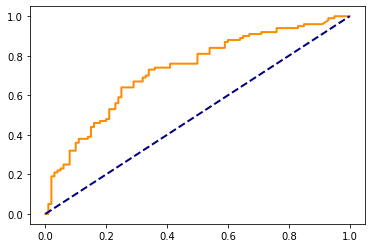

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Sy_val, Spred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [ ]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Spred_val > t).astype(int)
    metric = f1_score(Sy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.4335


We have obtained that our best threshold is at $t = 0.4355$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [ ]:
Spr_zeros = (np.array(Spred_zeros) > T).astype(int)

Spr_ones = (np.array(Spred_ones) > T).astype(int)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(248), np.zeros(597))), 
        np.concatenate((Spr_ones[100:], Spr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.8590    0.6734    0.7549       597
         1.0     0.4828    0.7339    0.5824       248

    accuracy                         0.6911       845
   macro avg     0.6709    0.7036    0.6687       845
weighted avg     0.7486    0.6911    0.7043       845



## SpamBase 4x4 Pure State

In [ ]:
# Given the eigenvalues this function return a Unitary gate which converts the |0> -> |lambda>
def create_U_train(x_train_param, seed=0):
  np.random.seed(seed)
  size_U = len(x_train_param)
  U_train = np.zeros((size_U, size_U))
  x_1 = x_train_param
  U_train[:, 0] = x_1
  for i in range(1, size_U):
    x_i = np.random.randn(size_U)
    for j in range(0, i):
      x_i -= x_i.dot(U_train[:, j]) * U_train[:, j]
    x_i = x_i/np.linalg.norm(x_i)
    U_train[:, i] = x_i
  
  return U_train

In [ ]:
phi_train = np.sum(np.abs(Strain), axis=0)
phi_train = phi_train / np.linalg.norm(phi_train)

U_train = create_U_train(phi_train)

print(U_train)

[[ 0.37950892  0.47081098  0.63630529 -0.47898392]
 [ 0.24651561 -0.12507789 -0.6121573  -0.74084345]
 [ 0.77958893 -0.56123548  0.13372207  0.24366829]
 [ 0.43294818  0.66910932 -0.44999715  0.40292823]]


We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained.

In [ ]:
backend = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [ ]:
## Density Estimation Approach matrices 4x4
Spred_ones = []

for i in range(len(Stest_ones)):

    qc = QuantumCircuit(2, 2)
    qc.initialize(Stest_ones[i], [0, 1])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend, shots=8000).result().get_counts()
    try:
        Spred_ones.append((counts['00'])/2000)
    except:
        Spred_ones.append(0)

print(Spred_ones)

# Works

[0.9695, 0.0135, 0, 0.9415, 0.717, 0.1385, 0.523, 0.481, 0.799, 0.53, 0.1395, 0.985, 2.417, 0.553, 0.3805, 1.175, 2.601, 0.1205, 1.627, 0.0195, 0.5285, 0.0175, 0.8075, 1.415, 1.499, 0.234, 0.8345, 0.604, 0.7245, 0, 0.114, 1.007, 1.0005, 1.471, 1.077, 0.2565, 0.298, 1.731, 0.6725, 1.943, 0.652, 1.7375, 0.4705, 0.1555, 1.6355, 0.411, 1.0835, 0.0815, 1.0705, 1.463, 1.3495, 1.803, 1.2195, 0.588, 1.719, 0.628, 2.07, 0.856, 0.2635, 0.9635, 0.152, 0.409, 0.4265, 0.435, 0.2885, 0.344, 0.6655, 0.0505, 2.046, 0.652, 0.9145, 0.012, 0.256, 0.5485, 0.7215, 0.039, 0.527, 0.8125, 0.422, 1.0955, 1.1475, 1.0205, 0.32, 0.7485, 0.797, 0.5945, 1.07, 0.839, 0.6775, 1.0445, 0.2335, 1.753, 1.3645, 1.13, 0.057, 0.546, 1.6005, 0.6895, 1.503, 1.5705, 1.0355, 1.2775, 1.194, 1.0575, 2.0825, 0.3025, 0.4575, 1.318, 0.309, 0.363, 0.176, 1.1935, 0.563, 0.56, 1.8125, 2.1995, 0.6985, 1.7225, 1.1045, 0.0415, 1.0925, 1.3435, 0.5555, 1.29, 1.8095, 0.6765, 0.38, 1.14, 0.6565, 0.473, 2.453, 0.551, 2.533, 0.5055, 0.563, 0.63

In [ ]:
# Pure state case
Spred_zeros = []

for i in range(len(Stest_zeros)):

    qc = QuantumCircuit(2, 2)
    qc.initialize(Stest_zeros[i], [0, 1])
    qc.isometry(U_train.T, [], [0, 1]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)

    counts = execute(qc, backend, shots=8000).result().get_counts()
    try:
        Spred_zeros.append((counts['00'])/2000)
    except:
        Spred_zeros.append(0)

print(Spred_zeros)

[0.1965, 0.3145, 0.0345, 0.152, 0.202, 0.2015, 0, 3.169, 0.118, 0.33, 0.3685, 0.3185, 0.2015, 0.3915, 0.009, 0.8, 0.0525, 0.5215, 0.4585, 0.0045, 0.426, 0.035, 0.0045, 0.121, 0.684, 0.0685, 0.7815, 0.51, 0.0525, 0.0565, 0.8245, 0.2465, 0.008, 0.3715, 0.4265, 0.2885, 0.3505, 0.674, 0.053, 0.0095, 1.8145, 0.787, 0.0175, 0.0035, 1.106, 0.389, 0.9925, 1.3535, 0.038, 0.075, 0.03, 0.0535, 0.1135, 0.748, 0.4475, 0.521, 0.002, 1.3545, 0.117, 1.15, 0.0015, 0.31, 0.0865, 0.0225, 0.5395, 0.3495, 0.9845, 0.2635, 0.0815, 0.081, 0.2665, 0.3605, 0.901, 0.49, 0.811, 0.3945, 0.548, 0.6915, 1.0115, 1.2205, 0.8645, 0.985, 0.05, 0.529, 0.1755, 0.0535, 0.156, 0.027, 0.171, 0.404, 0.0205, 0.005, 0.393, 0, 0.1065, 0.0065, 0.5175, 0.0045, 0.9535, 1.147, 0.062, 0.1895, 0.2845, 0.3535, 0.378, 0.0285, 0.059, 0.415, 1.2695, 0.598, 0.387, 0.4005, 0.091, 0.0095, 0.637, 0.0355, 0.009, 0.021, 0.0005, 0.154, 0.521, 0.336, 0.319, 0.008, 0.09, 0.34, 0.385, 0.014, 0.175, 0.1055, 0.149, 0.506, 0.0305, 0.0155, 0.442, 0.223

Once we have obtained the predicted density values, we need to determine a threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. For this, we will define a validation partition from our test groups, and we'll try to find the best possible value for $t$ using only validation samples. After that, we'll use this threshold to compare with all the remaining test samples. 

In [ ]:
Spred_val = np.concatenate((Spred_ones[:100], Spred_zeros[:100]))
print(Spred_val.shape)

Sy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Sy_val.shape)

(200,)
(200,)


0.72315


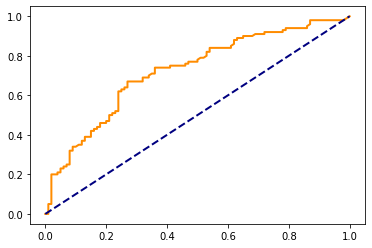

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Sy_val, Spred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [ ]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Spred_val > t).astype(int)
    metric = f1_score(Sy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.523


We have obtained that our best threshold is at $t = 0.523$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [ ]:
Spr_zeros = (np.array(Spred_zeros) > T).astype(int)

Spr_ones = (np.array(Spred_ones) > T).astype(int)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(248), np.zeros(597))), 
        np.concatenate((Spr_ones[100:], Spr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.8487    0.7420    0.7918       597
         1.0     0.5232    0.6815    0.5919       248

    accuracy                         0.7243       845
   macro avg     0.6859    0.7117    0.6919       845
weighted avg     0.7531    0.7243    0.7331       845



## SpamBase 8x8 Mixed State

In [ ]:
# Create the RandomFourierFeature map
dim = 8
rm_state = 2
sigma = 1  #dataset dependant
gamma = 1 / (2 * sigma**2)

feature_map_fourier = RBFSampler(gamma=gamma, n_components=dim, random_state=rm_state)
X_feat_train = feature_map_fourier.fit(spam_X)

rffmap = QFeatureMap_rff(rbf_sampler=feature_map_fourier)

Srff = rffmap.batch2wf(spam_X)

print(Srff.shape)

(3485, 8)


In [ ]:
Sones = []
Strain = []
Stest_zeros = []
Stest_ones = []

for i in range(Srff.shape[0]):
    if (spam_y[i] == 1):
        Sones.append(Srff[i] / np.linalg.norm(Srff[i]))
    elif (spam_y[i] == 0):
        Stest_zeros.append(Srff[i] / np.linalg.norm(Srff[i]))

Stest_ones = Sones[:len(Stest_zeros)//2]
Strain = Sones[len(Stest_zeros)//2:]

print(len(Strain))
print(len(Stest_zeros))
print(len(Stest_ones))

2440
697
348


In [ ]:
print(Strain[0])
print(sum(Strain[0]**2))

[-0.34027012 -0.40001974 -0.05008387 -0.25346561  0.53922711  0.19674345
  0.2569611  -0.51180502]
1.0


In [ ]:
Z_train = np.outer(np.abs(Strain[0]), np.abs(Strain[0]))
for i in range(1, len(Strain)):
    Z_train += np.outer(np.abs(Strain[i]), np.abs(Strain[i]))

Z_train *= 1/len(Strain)
print(Z_train)

[[0.06931959 0.08300347 0.04808967 0.04941927 0.09431502 0.07784292
  0.08019314 0.10130139]
 [0.08300347 0.15444103 0.07054571 0.07575444 0.15514609 0.13318578
  0.12967983 0.17259092]
 [0.04808967 0.07054571 0.05230964 0.042946   0.07962232 0.06815874
  0.06656479 0.08509469]
 [0.04941927 0.07575444 0.042946   0.06060161 0.08260872 0.07388889
  0.07581426 0.09218323]
 [0.09431502 0.15514609 0.07962232 0.08260872 0.17952542 0.14453548
  0.14385772 0.18738437]
 [0.07784292 0.13318578 0.06815874 0.07388889 0.14453548 0.13756255
  0.12806829 0.15965701]
 [0.08019314 0.12967983 0.06656479 0.07581426 0.14385772 0.12806829
  0.13534703 0.15830969]
 [0.10130139 0.17259092 0.08509469 0.09218323 0.18738437 0.15965701
  0.15830969 0.21089312]]


In [ ]:
lambda_P1_temp, U_train = np.linalg.eigh(Z_train)
lambda_train = round_lambda(lambda_P1_temp)
print(lambda_train)
print(U_train)

[0.00549852 0.00671934 0.00996441 0.97781773 0.01365931 0.01958209
 0.02544983 0.90645963]
[[ 0.00771802  0.15422668  0.42740079 -0.35756528 -0.30143132 -0.48259314
  -0.53267092  0.24111181]
 [-0.38476255 -0.19726171  0.43203748 -0.1121561   0.51696029 -0.16943225
   0.40003892  0.39727051]
 [ 0.07079513 -0.30775459 -0.04294226  0.73889489  0.23821596 -0.24075563
  -0.44276533  0.20424057]
 [-0.05922746  0.22554943 -0.22932215 -0.31234088  0.5380915   0.44017573
  -0.51343091  0.22037617]
 [-0.39890327  0.27235547 -0.64369821  0.03250565 -0.19428076 -0.32603283
   0.13665694  0.4342547 ]
 [ 0.00397229  0.54380302  0.37682723  0.41728872 -0.2362154   0.42731713
   0.09596151  0.37487011]
 [-0.17092392 -0.64697815 -0.03151477 -0.13364449 -0.44248959  0.43475375
  -0.10042811  0.37209755]
 [ 0.8093354  -0.05689074 -0.1374779  -0.15165173  0.07913371 -0.09365077
   0.24209212  0.47560492]]


In [ ]:
lambda_train = lambda_train / np.linalg.norm(lambda_train)
print(lambda_train)
print((sum(lambda_train**2)))

[0.00412226 0.00503751 0.00747034 0.7330724  0.01024042 0.01468074
 0.0190798  0.67957505]
1.0


We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained. This value will be proportional to the density estimated by the circuit.

In [ ]:
backend2 = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [ ]:
## Density Estimation Approach matrices 8x8
Spred_ones = []

for i in range(len(Stest_ones)):

    qc = QuantumCircuit(6, 3)

    qc.initialize(Stest_ones[i], [0, 1, 2])
    qc.initialize(lambda_train, [3, 4, 5])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.cnot(5, 2)
    qc.cnot(4, 1)
    qc.cnot(3, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)

    counts = execute(qc, backend2, shots=8000).result().get_counts()
    Spred_ones.append((counts['000'])/2000)

print(Spred_ones)

# Works

[0.039, 0.0435, 1.117, 0.3255, 0.045, 0.123, 0.14, 0.163, 0.026, 0.0255, 0.561, 0.1335, 0.185, 0.165, 0.0225, 0.242, 0.206, 0.159, 0.0565, 0.0465, 0.2335, 0.818, 0.092, 0.058, 0.1775, 0.366, 0.0165, 0.137, 0.0375, 0.5825, 0.085, 0.0255, 0.034, 0.026, 0.0685, 0.3805, 0.115, 0.239, 0.045, 0.1455, 0.872, 0.0365, 0.125, 0.3515, 0.207, 0.0025, 0.4415, 0.4365, 0.3965, 0.2615, 0.005, 0.0065, 0.0915, 0.0755, 0.057, 0.042, 0.2875, 0.186, 0.1915, 0.127, 0.835, 0.0455, 0.0295, 0.145, 0.172, 0.6405, 0.2565, 0.807, 0.049, 0.5165, 0.1025, 0.1315, 0.401, 0.0375, 0.1015, 0.3975, 0.159, 0.258, 0.068, 0.189, 0.075, 0.0555, 0.1655, 0.0305, 0.04, 0.027, 0.452, 0.077, 0.186, 0.4705, 0.3295, 0.044, 0.168, 0.9085, 1.1565, 0.131, 0.0275, 0.245, 0.036, 0.243, 0.443, 0.0145, 0.135, 0.0385, 0.01, 0.1245, 0.2615, 0.2425, 0.643, 0.582, 0.792, 0.009, 0.1535, 0.0635, 0.064, 0.02, 0.052, 0.028, 0.1135, 0.9465, 0.135, 0.034, 0.0615, 0.084, 0.173, 0.021, 0.06, 0.0955, 0.1095, 0.0105, 0.012, 0.1365, 0.0565, 0.031, 0.080

In [ ]:
# Mixed state case
Spred_zeros = []

for i in range(len(Stest_zeros)):

    qc = QuantumCircuit(6, 3)

    qc.initialize(Stest_zeros[i], [0, 1, 2])
    qc.initialize(lambda_train, [3, 4, 5])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.cnot(5, 2)
    qc.cnot(4, 1)
    qc.cnot(3, 0)

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)
    counts = execute(qc, backend2, shots=8000).result().get_counts()
    try:
        Spred_zeros.append((counts['000'])/2000)
    except:
        Spred_zeros.append(0)

print(Spred_zeros)

[0.064, 0.0195, 0.0715, 0.1255, 0.2005, 0.086, 0.901, 0.131, 0.0415, 0.024, 0.262, 0.0095, 0.013, 0.265, 0.1805, 0.1265, 0.414, 0.045, 0.2035, 0.427, 0.0435, 0.3365, 0.209, 0.1085, 0.135, 0.211, 0.0175, 0.0505, 0.3345, 0.293, 0.0125, 0.0145, 0.877, 0.0535, 0.049, 0.0165, 0.5055, 0.104, 0.132, 0.39, 0.008, 0.282, 0.005, 0.1105, 0.0425, 0.0005, 0.6415, 0.0595, 0.014, 0.5745, 0.0425, 0.153, 0.117, 0.3375, 0.02, 0.174, 0.085, 0.0245, 0.3095, 0.203, 0.304, 0.4415, 0.0025, 0.0065, 0.0115, 0.6535, 0.2605, 0.0135, 0.1065, 0.0885, 0.1245, 0.0535, 0.102, 0.1705, 0.003, 0.0655, 0.007, 0.025, 0.8185, 0.0335, 0.113, 0.4615, 0.108, 0.04, 0.257, 0.085, 0.0185, 0.2515, 0.289, 0.1195, 0.0955, 0.139, 0.0465, 0.114, 0, 0.0365, 0.098, 0.6135, 0.742, 0.1475, 0.1695, 0.1005, 0.039, 0.1555, 0.1395, 0.068, 0.332, 0.107, 0.161, 0.018, 0.0705, 0.061, 0.0315, 0.043, 0.0345, 0.088, 0.397, 0.066, 0.0825, 0.051, 0.0775, 0.109, 0.03, 0.0765, 0.123, 0.475, 0.004, 0.023, 0.2185, 0.025, 0.029, 0.0415, 0.652, 0.558, 0.0

Once we have obtained the predicted density values, we need to determine a threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. For this, we will define a validation partition from our test groups, and we'll try to find the best possible value for $t$ using only validation samples. After that, we'll use this threshold to compare with all the remaining test samples. 

In [ ]:
Spred_val = np.concatenate((Spred_ones[:100], Spred_zeros[:100]))
print(Spred_val.shape)

Sy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Sy_val.shape)

(200,)
(200,)


0.56485


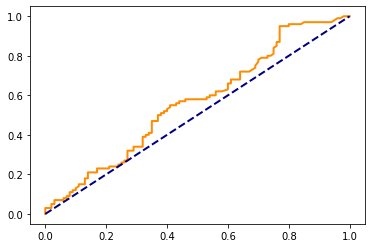

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Sy_val, Spred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [ ]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Spred_val > t).astype(int)
    metric = f1_score(Sy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.1245


We have obtained that our best threshold is at $t = 0.1245$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [ ]:
Spr_zeros = (np.array(Spred_zeros) > T).astype(int)

Spr_ones = (np.array(Spred_ones) > T).astype(int)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(248), np.zeros(597))), 
        np.concatenate((Spr_ones[100:], Spr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.7559    0.5913    0.6635       597
         1.0     0.3545    0.5403    0.4281       248

    accuracy                         0.5763       845
   macro avg     0.5552    0.5658    0.5458       845
weighted avg     0.6381    0.5763    0.5944       845



## SpamBase 8x8 Pure State

In [ ]:
phi_train = np.sum(np.abs(Strain), axis=0)
phi_train = phi_train / np.linalg.norm(phi_train)

U_train = create_U_train(phi_train)

print(U_train)

[[ 2.42533676e-01  3.92465306e-01 -6.70307607e-01  2.91091225e-01
   2.67895241e-01 -4.20590156e-01 -6.43884790e-02 -1.70937208e-02]
 [ 3.96977281e-01 -1.22555550e-01  3.64045805e-02  2.60429951e-02
  -6.95863502e-01 -2.91149292e-01 -5.06351380e-01 -3.63535790e-05]
 [ 2.06555201e-01  1.73205406e-01 -2.28882531e-01  7.00712557e-02
  -2.51969816e-01  5.40217153e-01  1.42867681e-01 -7.03066929e-01]
 [ 2.22028386e-01  5.51803480e-01  6.94026834e-01  2.93379612e-01
   1.23616632e-01 -1.80470956e-01  3.93990677e-02 -1.70494422e-01]
 [ 4.33649605e-01  3.06048557e-01 -5.08853786e-03 -7.41394147e-01
   2.34198061e-01  2.05822626e-01 -2.12803105e-01  1.61537237e-01]
 [ 3.73541690e-01 -5.31680987e-01  1.05928774e-01  2.79501890e-01
   5.36466451e-01  1.51244397e-01 -3.80668763e-01 -1.81272982e-01]
 [ 3.71143602e-01  6.25581780e-02 -4.59237958e-02  3.98627595e-01
  -1.48527718e-01  4.65894247e-01  2.29219143e-01  6.36919617e-01]
 [ 4.75701431e-01 -3.40881226e-01  4.41153768e-02 -1.92134164e-01
  -

We will need a different circuit for each sample $|x \rangle$ in the test partition. To obtain a more accurate predicted value, we will run the circuit many shots, and then we will store the amount of $|00 \rangle$ obtained.

In [ ]:
backend = Aer.get_backend('qasm_simulator')
np.random.seed(1234)

In [ ]:
## Density Estimation Approach matrices 8x8
Spred_ones = []

for i in range(len(Stest_ones)):

    qc = QuantumCircuit(3, 3)
    qc.initialize(Stest_ones[i], [0, 1, 2])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)

    counts = execute(qc, backend, shots=8000).result().get_counts()
    try:
        Spred_ones.append((counts['000'])/2000)
    except:
        Spred_ones.append(0)

print(Spred_ones)

# Works

[0.0275, 0, 0.0505, 0.002, 0.0015, 0.065, 0.017, 0.0085, 0.0015, 0.022, 0.0045, 0.0005, 0.0895, 0.032, 0.024, 0.155, 0.4805, 0.0435, 0.128, 0.0895, 0.4935, 1.6055, 0.001, 0.137, 0.008, 0.01, 0.0175, 0.0055, 0.0075, 0.744, 0.0205, 0.055, 0.0175, 0.0045, 0.0095, 0.0015, 0, 0.0155, 0.0835, 0.221, 0.1505, 0.0055, 0.0505, 0.0055, 0.0855, 0.0055, 0.8515, 0.522, 0.073, 0.515, 0.0015, 0, 0.021, 0.027, 0.061, 0.0035, 0.2645, 0.004, 0.005, 0.238, 1.5505, 0.021, 0.0235, 0.0015, 0, 1.054, 0.0375, 1.4595, 0.075, 0.074, 0.0065, 0.0115, 0.019, 0.014, 0.0065, 0.076, 0.007, 0.3075, 0.0085, 0.0165, 0.001, 0, 0.023, 0.051, 0.017, 0.0065, 0.8465, 0.128, 0.0415, 0.8345, 0.0265, 0.014, 0.3315, 0.0095, 1.8025, 0.0085, 0.011, 0.03, 0.007, 0.0635, 0.817, 0.001, 0.076, 0.0085, 0.008, 0.001, 0.001, 0.072, 0.5335, 1.0365, 1.1715, 0.0115, 0.2505, 0.096, 0.0155, 0.0435, 0.02, 0.0485, 0.0955, 1.228, 0.059, 0.0145, 0.001, 0.027, 0.0035, 0.004, 0.016, 0.1, 0.0055, 0.012, 0.0205, 0.0055, 0.0005, 0.061, 0.0125, 0.01, 0.

In [ ]:
# Pure state case
Spred_zeros = []

for i in range(len(Stest_zeros)):

    qc = QuantumCircuit(3, 3)
    qc.initialize(Stest_zeros[i], [0, 1, 2])
    qc.isometry(U_train.T, [], [0, 1, 2]) # ArbRot as a isometry

    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.measure(2, 2)

    counts = execute(qc, backend, shots=8000).result().get_counts()
    try:
        Spred_zeros.append((counts['000'])/2000)
    except:
        Spred_zeros.append(0)

print(Spred_zeros)

[0.061, 0.0225, 0.0355, 0.037, 0.0105, 0.04, 0.0135, 0.126, 0.0425, 0, 0.025, 0.0005, 0.0035, 0.2895, 0.0555, 0.067, 0.2375, 0.07, 0.0405, 0.042, 0.0635, 0.0015, 0.012, 0.053, 0.094, 0.092, 0.026, 0.083, 0.006, 0, 0.0005, 0.0255, 0.0015, 0.1215, 0.001, 0.026, 0.1305, 0.035, 0.001, 0.059, 0.007, 0.0665, 0.012, 0.002, 0, 0, 0.1135, 0.0205, 0.017, 0.109, 0.004, 0.0015, 0.0005, 0.1435, 0.001, 0, 0.0185, 0.001, 0.0535, 0.399, 0.0505, 0.121, 0.0045, 0.0015, 0, 0.069, 0.048, 0.012, 0, 0.0765, 0.162, 0.0185, 0.209, 0.0335, 0.008, 0.11, 0.01, 0.039, 0.0395, 0.001, 0.0285, 0.0575, 0.0175, 0.071, 0.031, 0.033, 0.001, 0.03, 0.0175, 0.001, 0.0255, 0.018, 0.004, 0.2395, 0, 0.0585, 0.1205, 0.273, 0.022, 0.292, 0.0685, 0.1775, 0, 0.0485, 0.0535, 0.084, 0.016, 0.001, 0.2905, 0.0075, 0.116, 0.101, 0, 0.083, 0.0235, 0.071, 0.6065, 0.0695, 0.0665, 0, 0.003, 0.0115, 0.005, 0.0235, 0.0185, 0.9595, 0.0005, 0.0095, 0.1295, 0.02, 0.002, 0.098, 0.021, 0.2765, 0.058, 0.009, 0.029, 0.032, 0.0045, 0.126, 0.1055, 0

Once we have obtained the predicted density values, we need to determine a threshold $t$ such that if a sample has a density lower than $t$, it is classified as an outlier. For this, we will define a validation partition from our test groups, and we'll try to find the best possible value for $t$ using only validation samples. After that, we'll use this threshold to compare with all the remaining test samples. 

In [ ]:
Spred_val = np.concatenate((Spred_ones[:100], Spred_zeros[:100]))
print(Spred_val.shape)

Sy_val = np.concatenate((np.ones(100), np.zeros(100)))
print(Sy_val.shape)

(200,)
(200,)


0.5305


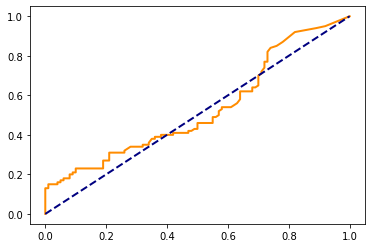

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Sy_val, Spred_val, pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange",
    lw=lw, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
print(auc(fpr, tpr))

In [ ]:
from sklearn.metrics import f1_score

m, T = 0,0
for t in thresholds:
    preds = (Spred_val > t).astype(int)
    metric = f1_score(Sy_val, preds, average='weighted')
    if (metric > m):    
        m = metric
        T = t

print(T)

0.073


We have obtained that our best threshold is at $t = 0.073$. So we will use this threshold to compare all test samples and to calculate some metrics for our estimator.

In [ ]:
Spr_zeros = (np.array(Spred_zeros) > T).astype(int)

Spr_ones = (np.array(Spred_ones) > T).astype(int)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
        np.concatenate((np.ones(248), np.zeros(597))), 
        np.concatenate((Spr_ones[100:], Spr_zeros[100:])), digits=4))

              precision    recall  f1-score   support

         0.0     0.6971    0.6901    0.6936       597
         1.0     0.2717    0.2782    0.2749       248

    accuracy                         0.5692       845
   macro avg     0.4844    0.4842    0.4843       845
weighted avg     0.5723    0.5692    0.5707       845



## Acknowledgements

The team thanks specially to our mentor Fabio González for his valuable help and support. Also, we acknowledge the use of IBM Quantum services.

## References

[González2021] Fabio  A.  González,  Alejandro  Gallego,  Santiago  Toledo-Cortés,  and Vladimir Vargas-Calderón.  Learning with Density Matrices and Random Features.  2021.  URL http://arxiv.org/abs/2102.04394.

[QTML2021] Fabio A. González,  Vladimir Vargas-Calderón, Alejandro Gallego, Herbert Vinck-Posada. NON-PARAMETRIC MULTIVARIATE CONTINUOUS DENSITY ESTIMATION IN A QUANTUM COMPUTER. 2021.

[Useche2021] Diego H Useche, Andres Giraldo-Carvajal, Hernan M Zuluaga-Bucheli, Jose A Jaramillo-Villegas, and Fabio A González. Quantum measurement classification with qudits. arXiv preprint arXiv:2107.09781, 2021.

[Parzen1962] Parzen, E. On estimation of a probability density function and mode. The annals of mathematical statistics, 33(3): 1065–1076, 1962	

[Rahimi2007] Rahimi, A. and Recht, B. Random features for large-scale kernel machines. In Proceedings of the 20th International Conference on Neural Information Processing Systems, NIPS’07, pp. 1177–1184, Red Hook, NY, USA, 2007. Curran Associates Inc. ISBN 9781605603520.